# Offline batch Q-Learning: Hidden layer
In this part, a random policy is used to learn. 2000 episdoes are recorded and used to train Q-network weights

# Running this file
Run the first two cells and proceed as instucted


In [1]:
import sys
import math
import random
import pdb
import numpy as np
import tensorflow as tf
import gym
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib
import os
warnings.filterwarnings('ignore')

In [2]:
# create a network that  will be used to take the loss.
def create_network(state, action, next_state, reward, hidden, alpha, n_hidden=100, discount=0.99):

    if hidden == True:
        weights = {'w1': tf.Variable(tf.random_uniform([4, n_hidden], 0, 0.01)),
                   'w2': tf.Variable(tf.random_uniform([n_hidden, 2], 0, 0.01))}
        biases = {'b1': tf.Variable(tf.random_uniform([n_hidden], 0, 0.01)),
                  'b2': tf.Variable(tf.random_uniform([2], 0, 0.01))}

        hidden = tf.nn.relu(tf.matmul(state, weights['w1']) + biases['b1'])
        q = tf.matmul(hidden, weights['w2']) + biases['b2']

        hidden = tf.nn.relu(tf.matmul(next_state, weights['w1']) + biases['b1'])
        q_prime = tf.matmul(hidden, weights['w2']) + biases['b2']
    
    
    
    delta = reward + 1   # don't boostrap if state is terminal
    q_prime_max = tf.reshape(tf.reduce_max(q_prime, reduction_indices=[1]), [-1, 1])
    #q_max = tf.reshape(tf.reduce_max(q, reduction_indices=[1]), [-1, 1])
    qa = tf.reshape(tf.gather_nd(q, action), [-1, 1])
    diff = tf.square(reward + discount * tf.multiply(delta, tf.stop_gradient(q_prime_max)) - qa) / 2
    loss = tf.reduce_mean(diff)
    opt = tf.train.RMSPropOptimizer(alpha, 0.95, 0.0, 1e-7).minimize(loss)
    #hidden
    #opt = tf.train.RMSPropOptimizer(alpha, 0.99, 0.0, 1e-6).minimize(loss)
    #opt = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)
    return opt, q, loss

In [3]:
def get_placeholders():
    state = tf.placeholder("float", [None, 4])
    action = tf.placeholder(tf.int32, [None, 2])
    next_state = tf.placeholder("float", [None, 4])
    reward = tf.placeholder("float", [None, 1])
    return state, action, next_state, reward

# Do not run these cells...
Continue to load data below to load models, otherwise training will begin

In [20]:
n_episodes = 2000
max_eps_length = 300
alpha_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5]
n_epochs = 50
discount = 0.99
hidden = True
freq = 2
n_episodes = 50
batch_size = 64

In [21]:
random_policy_data = np.load("./random_policy_data4.npy") 

In [22]:
# Need to save the model, weights and biases varibles

# Suggested Directory to use
save_MDir = 'new_models/A3_ii/'


#create the directory if it does not exist already
if not os.path.exists(save_MDir):
    os.makedirs(save_MDir)

#save_model = os.path.join(save_MDir,'best_lr')

In [23]:
start = time.time()
count = 0
total_lengths = []
total_return = []
total_loss = []
max_lengths = [0]
for alpha in alpha_list:
        print('------------Begining to run experiment with learning rate: {} ------------'.format(alpha))
        tf.reset_default_graph()
        env = gym.make('CartPole-v0')
        env._max_episode_steps = 300
        # placeholders
        state, action, next_state, reward = get_placeholders()
        
        #setup graph
        opt, q, loss = create_network(state, action, next_state, reward, hidden, alpha=alpha)
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        av_len = []
        av_ret = []
        episode_loss = []

        ##------------- Train on batches and evaluate
        with tf.Session() as sess:
            sess.run(init)
            
            for epoch in range(n_epochs):
                # every second episode test
                if epoch % freq == 0:
                    episode_length = []
                    episode_return = []

                    for episode_i in range(n_episodes):
                        s = env.reset()

                        for t in range(300):
                            this_q = sess.run(q, feed_dict={state: s.reshape(1, 4)})
                            #ac_greedily
                            a = np.argmax(this_q)
                            
                            s_prime, rwd, done, info = env.step(a)

                            if done:
                                episode_length.append(t+1)
                                episode_return.append(-1 * discount**t)
                                break
                            s = s_prime

                    av_len.append(np.mean(np.array(episode_length)))
                    av_ret.append(np.mean(np.array(episode_return)))
                    

                n_batches = int(random_policy_data.shape[0] / batch_size)
                # every epoch run optimize over the batches
                for batch_i in range(n_batches):
                    batch = random_policy_data[batch_i*batch_size:(batch_i+1)*batch_size, :]
                    act = batch[:-1, 4].reshape(-1, 1)
                    act = np.append(np.arange(len(act)).reshape(-1, 1), act, axis=1)
                    batch_dict = {
                        state: batch[:-1, :4],
                        action: act,
                        next_state: batch[1:, :4],
                        reward: batch[:-1, -1].reshape(-1, 1)
                    }
                    _, l = sess.run([opt, loss], feed_dict=batch_dict)

                if epoch % freq == 0:
                    episode_loss.append(l)
                    print('The loss of epoch {} is {} with average length {} and return {}'.format(epoch+1,l,av_len[-1],av_ret[-1]))
                #---------------------------------------------------------------

            # save_path = saver.save(sess, '../../models/part1/batch_q/tf_model')
            file_name = "A3%ii.ckpt" %(int(alpha*100000))
            
            max_lengths.append(max(av_len))
            if max(av_len) == max(max_lengths):
 
                save_model = os.path.join(save_MDir,file_name)
                saver.save(sess= sess, save_path = save_model)
                print('model {} is the best yet!'.format(alpha))
            


        total_lengths.append(av_len)
        total_return.append(av_ret)
        total_loss.append(episode_loss)
        
total_lengths= np.asarray(total_lengths).reshape(-1,1)
total_return = np.asarray(total_return).reshape(-1,1)
total_loss = np.asarray(total_loss).reshape(-1,1)

saved_data  = np.concatenate((total_lengths, total_return,total_loss), axis=1)
print(time.time()-start)


[2017-04-06 21:19:28,788] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 1e-05 ------------
The loss of epoch 1 is 0.03974126651883125 with average length 9.36 and return -0.9194376892909321
The loss of epoch 3 is 0.03857707604765892 with average length 9.16 and return -0.9212850800930978
The loss of epoch 5 is 0.03702489286661148 with average length 9.36 and return -0.9194358438015433
The loss of epoch 7 is 0.034532397985458374 with average length 18.86 and return -0.8358479002748623
The loss of epoch 9 is 0.031022459268569946 with average length 22.1 and return -0.8095010246164362
The loss of epoch 11 is 0.026757342740893364 with average length 9.5 and return -0.9181458467187329
The loss of epoch 13 is 0.022228257730603218 with average length 9.68 and return -0.9164830048554531
The loss of epoch 15 is 0.018107876181602478 with average length 9.32 and return -0.9198049603206215
The loss of epoch 17 is 0.01483259815722704 with average length 9.26 and return -0.9203641995293655
The loss of epoch 19 i

[2017-04-06 21:20:06,277] Making new env: CartPole-v0


model 1e-05 is the best yet!
------------Begining to run experiment with learning rate: 0.0001 ------------
The loss of epoch 1 is 0.034968744963407516 with average length 9.22 and return -0.9207314332764409
The loss of epoch 3 is 0.004480994306504726 with average length 9.46 and return -0.9185111976938057
The loss of epoch 5 is 0.006094911135733128 with average length 94.0 and return -0.4579435673861932
The loss of epoch 7 is 0.008288762532174587 with average length 127.96 and return -0.37615105340448257
The loss of epoch 9 is 0.008590719662606716 with average length 109.66 and return -0.3765503395979399
The loss of epoch 11 is 0.007724173832684755 with average length 204.8 and return -0.1781851261088945
The loss of epoch 13 is 0.0066734314896166325 with average length 274.0 and return -0.0729572541449569
The loss of epoch 15 is 0.005747595801949501 with average length 268.72 and return -0.07370174993894986
The loss of epoch 17 is 0.006138301454484463 with average length 282.38 and re

[2017-04-06 21:21:26,197] Making new env: CartPole-v0


model 0.0001 is the best yet!
------------Begining to run experiment with learning rate: 0.001 ------------
The loss of epoch 1 is 0.007574800401926041 with average length 9.3 and return -0.9199969098583693
The loss of epoch 3 is 0.02965276688337326 with average length 261.9 and return -0.07800181662656405
The loss of epoch 5 is 0.2202066034078598 with average length 197.96 and return -0.16330100752320245
The loss of epoch 7 is 0.831720769405365 with average length 200.46 and return -0.16259890729650034
The loss of epoch 9 is 2.2372403144836426 with average length 199.2 and return -0.15808741872890889
The loss of epoch 11 is 4.913187503814697 with average length 192.42 and return -0.16528826290067464
The loss of epoch 13 is 9.458134651184082 with average length 210.58 and return -0.14226108596160858
The loss of epoch 15 is 16.597665786743164 with average length 206.22 and return -0.144447260855728
The loss of epoch 17 is 27.166234970092773 with average length 206.88 and return -0.14378

[2017-04-06 21:22:48,578] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 0.01 ------------
The loss of epoch 1 is 0.03196027874946594 with average length 9.36 and return -0.9194358438015433
The loss of epoch 3 is 2.069122314453125 with average length 195.1 and return -0.16030532452749963
The loss of epoch 5 is 16.65104866027832 with average length 128.42 and return -0.2869970605490829
The loss of epoch 7 is 51.477928161621094 with average length 166.44 and return -0.21147010570824432
The loss of epoch 9 is 101.34864807128906 with average length 208.36 and return -0.13891660453873217
The loss of epoch 11 is 149.78387451171875 with average length 216.22 and return -0.1278489728349152
The loss of epoch 13 is 178.56434631347656 with average length 230.32 and return -0.1092403919698717
The loss of epoch 15 is 173.8425750732422 with average length 230.24 and return -0.10986886834005055
The loss of epoch 17 is 138.73904418945312 with average length 240.68 and return -0.0973676611687135
The loss of epoch 19

[2017-04-06 21:23:52,396] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 0.1 ------------
The loss of epoch 1 is 1.2599743604660034 with average length 9.42 and return -0.9188858879636643
The loss of epoch 3 is 875.182861328125 with average length 171.64 and return -0.20206286198964551
The loss of epoch 5 is 6742.603515625 with average length 119.0 and return -0.31469067220717384
The loss of epoch 7 is 5882.57763671875 with average length 101.5 and return -0.3666128048661232
The loss of epoch 9 is 2423.9599609375 with average length 87.12 and return -0.4211776419349029
The loss of epoch 11 is 271.9685363769531 with average length 77.38 and return -0.46454503589650364
The loss of epoch 13 is 70.56590270996094 with average length 125.74 and return -0.2861961956159006
The loss of epoch 15 is 79.02387237548828 with average length 87.48 and return -0.41974565805163555
The loss of epoch 17 is 25.89985466003418 with average length 78.88 and return -0.45756498270456075
The loss of epoch 19 is 28.50051498413

[2017-04-06 21:24:47,719] Making new env: CartPole-v0


------------Begining to run experiment with learning rate: 0.5 ------------
The loss of epoch 1 is 94578.46875 with average length 9.22 and return -0.9207332974071367
The loss of epoch 3 is 17633604.0 with average length 172.82 and return -0.20408586033706197
The loss of epoch 5 is 221839424.0 with average length 170.86 and return -0.20373493211337362
The loss of epoch 7 is 1085505792.0 with average length 190.16 and return -0.16945090986934963
The loss of epoch 9 is 3413771520.0 with average length 192.2 and return -0.1675158782249183
The loss of epoch 11 is 8353957888.0 with average length 185.24 and return -0.17808316674860186
The loss of epoch 13 is 17410912256.0 with average length 185.34 and return -0.17677620297705596
The loss of epoch 15 is 32471906304.0 with average length 177.52 and return -0.18474846981709372
The loss of epoch 17 is 55805341696.0 with average length 168.66 and return -0.20445192709241833
The loss of epoch 19 is 90034601984.0 with average length 181.34 and re

In [24]:
filename = './results/New_batch_q_ii_results.csv'
np.savetxt(filename, saved_data, delimiter=' ,')

In [25]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


In [26]:
num=int(n_epochs/2)
#num  = 5

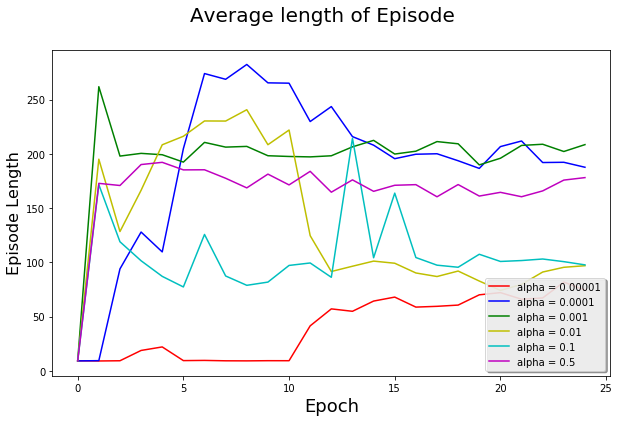

In [27]:
t = np.linspace(0,num-1,num)
colours = ['r','b','g','y','c','m']
labels = ['0.00001','0.0001','0.001','0.01','0.1','0.5']
fig = plt.figure()
for k in range(6):
    #print(i)
    plt.plot(t,saved_data[k*num:(k+1)*num,0],colours[k], label = 'alpha = '+ labels[k]) # plotting t,a separately 

fig.suptitle('Average length of Episode', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Episode Length', fontsize=16)
plt.show()
fig.savefig('./results/pics/Final_H_Lengths.jpg')

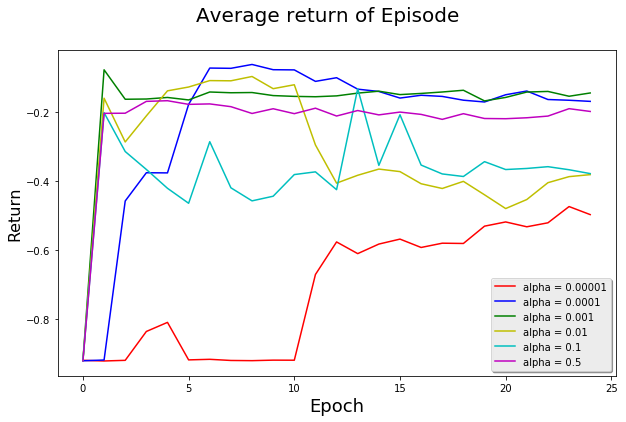

In [28]:
t = np.linspace(0,num-1,num)
colours = ['r','b','g','y','c','m']
labels = ['0.00001','0.0001','0.001','0.01','0.1','0.5']
fig = plt.figure()
for k in range(6):
    #print(i)
    plt.plot(t,saved_data[k*num:(k+1)*num,1],colours[k], label = 'alpha = '+ labels[k]) # plotting t,a separately 

fig.suptitle('Average return of Episode', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Return', fontsize=16)
plt.show()
fig.savefig('./results/pics/Final_H_Returns.jpg')

In [ ]:
t = np.linspace(0,num-1,num)
colours = ['r','b','g','y','c','m']
labels = ['0.00001','0.0001','0.001','0.01','0.1','0.5']
#fig = plt.figure()
count = 0
f2, axar = plt.subplots(2, 3)

#for k in range(6):
for j in range(2):
    for i in range(3):
            axar[j, i].plot(t,saved_data[count*num:(count+1)*num,2],colours[count])
            axar[j, i].set_title('learning rate {}'.format(alpha_list[count]))
            count+=1

fig.suptitle('Loss of epoch', fontsize=20)
legend = plt.legend(loc='lower right', shadow=True)

f2.subplots_adjust(hspace=0.7)
plt.savefig('./results/pics/Final_H_Loss.png')
plt.show()

# Load Model
Load the model of the best learning rate. Output the Average return and episode length

In [4]:
alpha = 0.001
file_name = "A3%i.ckpt" %(int(alpha*100000))
save_MDir = 'new_models/A3_ii/'
save_model = os.path.join(save_MDir,file_name)
init = tf.global_variables_initializer()
print(save_model)

new_models/A3_ii/A3100.ckpt


In [5]:
def test_epoch(sess, test_episodes):   
    e_length = []
    e_return = []
    av_len = []
    av_ret = []
    for _ in range(test_episodes):
        s = env.reset()
        
        for t in range(300):
            this_q = sess.run(q, feed_dict={state: s.reshape(1, 4)})
            #ac_greedily
            a = np.argmax(this_q)

            s_prime, rwd, done, info = env.step(a)

            if done:
                e_length.append(t+1)
                e_return.append(-1 * discount**t)
                break
            s = s_prime
    return e_length, e_return

In [6]:
tf.reset_default_graph()
hidden  = True
discount = 0.99
env = gym.make('CartPole-v0')
env._max_episode_steps = 300

state, action, next_state, reward = get_placeholders()
opt, q, loss = create_network(state, action, next_state, reward, hidden, alpha=alpha)
init  = tf.global_variables_initializer()
test_episodes = 50
"""---------------- restore model after training  --------------------------"""
# restore model and calculate mean length and return over n_test episodes
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(init)
    saver.restore(sess = sess, save_path= save_model)
    print("Restored values for learning rate: ",alpha)
    restored_length, restored_return = test_epoch(sess,50)
    print('The average length of episode is: {} with std: {} '.format(np.mean(restored_length),np.std(restored_length)))
    print('The average return of episode is: {} with std: {} '.format(np.mean(restored_return),np.std(restored_return)))


[2017-04-11 20:25:51,130] Making new env: CartPole-v0


Restored values for learning rate:  0.001
The average length of episode is: 202.82 with std: 58.46834699219742 
The average return of episode is: -0.1530519814555962 with std: 0.07515422783282652 


In [61]:
len(restored_length)

50